In [ ]:
 # pip install "dask[complete]" dask-ml pandas matplotlib


Note: you may need to restart the kernel to use updated packages.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import os

# Initialize Spark session with increased memory allocations
spark = SparkSession.builder \
    .appName("Advanced Analysis on 700GB Data") \
    .master("local[*]") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "16g") \
    .config("spark.sql.shuffle.partitions", "400") \
    .config("spark.memory.offHeap.enabled", True) \
    .config("spark.memory.offHeap.size", "8g") \
    .getOrCreate()

# Directory to save intermediate results
output_dir = "output_batches"
os.makedirs(output_dir, exist_ok=True)

# Read the dataset (partitioned Parquet)
input_dir = "parquet_database"
df = spark.read.parquet(input_dir)

# Configure batch size and start processing
batch_size = 10000  # Adjust batch size based on available memory
partition_col = "receivedate"  # Partitioning column for iterative processing

# Get unique partition keys
partition_keys = df.select(partition_col).distinct().collect()

# Process each partition key iteratively
for key_row in partition_keys:
    partition_value = key_row[partition_col]
    print(f"Processing partition: {partition_value}")

    # Filter for the current partition
    partition_df = df.filter(col(partition_col) == partition_value)

    # Break into smaller batches and process
    total_records = partition_df.count()
    print(f"Total records in partition {partition_value}: {total_records}")
    batches = (total_records // batch_size) + 1

    for batch_num in range(batches):
        # Get the batch
        batch_df = partition_df.limit(batch_size).cache()

        # Perform your analysis or transformation here
        # Example: Count serious reports by patient sex
        serious_reports = (
            batch_df.filter(col("serious") == "1")
            .groupBy(col("`patient.patientsex`"))
            .count()
        )

        # Save intermediate results
        batch_output_path = os.path.join(output_dir, f"{partition_value}_batch_{batch_num}.parquet")
        serious_reports.write.mode("overwrite").parquet(batch_output_path)
        print(f"Saved batch {batch_num} for partition {partition_value} to {batch_output_path}")

        # Release memory
        batch_df.unpersist()

    # Optional: Save processed partition marker
    with open(os.path.join(output_dir, f"{partition_value}_processed.txt"), "w") as marker:
        marker.write(f"Processed partition: {partition_value}\n")

print("Processing complete!")


24/12/10 14:49:58 WARN Utils: Your hostname, Abhinavs-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.16 instead (on interface en0)
24/12/10 14:49:58 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/10 14:49:58 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/py4j/java_gateway

#
# A fatal error has been detected by the Java Runtime Environment:
#
#  SIGSEGV (0xb) at pc=0x000000010574911c, pid=63922, tid=80387
#
# JRE version: OpenJDK Runtime Environment Homebrew (11.0.25) (build 11.0.25+0)
# Java VM: OpenJDK 64-Bit Server VM Homebrew (11.0.25+0, mixed mode, tiered, compressed oops, g1 gc, bsd-aarch64)
# Problematic frame:
# [thread 81155 also had an error]
[thread 70915 also had an error]
V  [libjvm.dylib+0x69511c]  ObjectSynchronizer::inflate(Thread*, oopDesc*, ObjectSynchronizer::InflateCause)+0x18c
#
# No core dump will be written. Core dumps have been disabled. To enable core dumping, try "ulimit -c unlimited" before starting Java again
#
# An error report file with more information is saved as:
# /Users/abhinavsivanandhan/Downloads/BigDataProject/hs_err_pid63922.log
#
# If you would like to submit a bug report, please visit:
#   https://github.com/Homebrew/homebrew-core/issues
#


Py4JError: An error occurred while calling o36.parquet

In [ ]:
df = spark.read.parquet("parquet_database")
df = df.repartition(200)  # Adjust based on available memory


In [ ]:
# 1. Analyze Serious Reports by Patient Age and Sex


+------------------+-----------------------+-----+
|patient.patientsex|patient.patientonsetage|count|
+------------------+-----------------------+-----+
|                 2|                   NULL| 5060|
|                 1|                   NULL| 2926|
|              NULL|                   NULL| 1476|
|                 0|                   NULL|  380|
|                 2|                     60|  350|
|                 2|                     55|  295|
|                 2|                     64|  285|
|                 2|                     53|  284|
|                 2|                     70|  282|
|                 2|                     63|  277|
+------------------+-----------------------+-----+
only showing top 10 rows



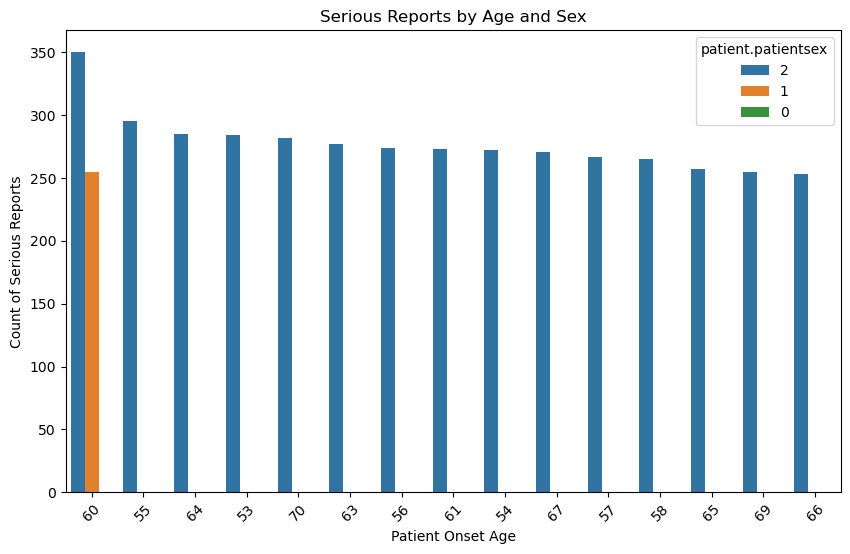

In [ ]:
from pyspark.sql.functions import col

# Filter serious reports and group by patient sex and onset age
serious_reports = (
    df.filter(col("serious") == "1")  # Filter serious cases
    .groupBy(col("`patient.patientsex`"), col("`patient.patientonsetage`"))  # Use explicit references for nested fields
    .count()
    .orderBy(col("count").desc())
)

serious_reports.show(10)

# Convert to Pandas for visualization
serious_reports_pd = serious_reports.toPandas()

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(
    x="patient.patientonsetage",
    y="count",
    hue="patient.patientsex",
    data=serious_reports_pd.head(20),
)
plt.xlabel("Patient Onset Age")
plt.ylabel("Count of Serious Reports")
plt.title("Serious Reports by Age and Sex")
plt.xticks(rotation=45)
plt.show()


In [ ]:
df.printSchema()

root
 |-- safetyreportid: string (nullable = true)
 |-- transmissiondateformat: string (nullable = true)
 |-- transmissiondate: string (nullable = true)
 |-- serious: string (nullable = true)
 |-- receivedateformat: string (nullable = true)
 |-- receiptdateformat: string (nullable = true)
 |-- receiptdate: string (nullable = true)
 |-- fulfillexpeditecriteria: string (nullable = true)
 |-- companynumb: string (nullable = true)
 |-- receiver: double (nullable = true)
 |-- primarysource.reportercountry: string (nullable = true)
 |-- primarysource.qualification: string (nullable = true)
 |-- sender.senderorganization: string (nullable = true)
 |-- patient.patientsex: string (nullable = true)
 |-- patient.reaction: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- reactionmeddrapt: string (nullable = true)
 |    |    |-- reactionmeddraversionpt: string (nullable = true)
 |    |    |-- reactionoutcome: string (nullable = true)
 |-- patient.drug: array (n

In [ ]:
# Query 2: Predict Likelihood of Serious Reports (Binary Classification)

In [ ]:
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Index the label column to ensure binary classification
label_indexer = StringIndexer(inputCol="serious", outputCol="label")
indexed_df = label_indexer.fit(df).transform(df)

# Select features and label
ml_df = indexed_df.select(
    col("label"),  # Target variable
    col("`patient.patientsex`").cast("int").alias("patientsex"),
    col("`patient.patientonsetage`").cast("double").alias("onsetage"),
    col("`patient.patientweight`").cast("double").alias("patientweight"),
).na.drop()  # Drop null values

# Assemble features
assembler = VectorAssembler(
    inputCols=["patientsex", "onsetage", "patientweight"],
    outputCol="features"
)
ml_df = assembler.transform(ml_df)

# Split data into training and test sets
train, test = ml_df.randomSplit([0.8, 0.2], seed=42)

# Train Logistic Regression Model
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10)
lr_model = lr.fit(train)

# Evaluate the model
predictions = lr_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)

print(f"Area Under Curve (AUC): {auc}")

# Feature Importance
coefficients = lr_model.coefficients
feature_importance = list(zip(["patientsex", "onsetage", "patientweight"], coefficients))

print("Feature Importance:")
for feature, coeff in feature_importance:
    print(f"{feature}: {coeff:.4f}")


ERROR:root:Exception while sending command.==>                   (41 + 12) / 65]
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/py4j/clientserver.py", line 516, in send_command
    raise Py4JNetworkError("Answer from Java side is empty")
py4j.protocol.Py4JNetworkError: Answer from Java side is empty

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/py4j/clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending or receiving


#
# A fatal error has been detected by the Java Runtime Environment:
#
#  SIGSEGV (0xb) at pc=0x000000010549511c, pid=60159, tid=81675
#
# JRE version: OpenJDK Runtime Environment Homebrew (11.0.25) (build 11.0.25+0)
# Java VM: OpenJDK 64-Bit Server VM Homebrew (11.0.25+0, mixed mode, tiered, compressed oops, g1 gc, bsd-aarch64)
# Problematic frame:
# V  [libjvm.dylib+0x69511c]  ObjectSynchronizer::inflate(Thread*, oopDesc*, ObjectSynchronizer::InflateCause)+0x18c
#
# No core dump will be written. Core dumps have been disabled. To enable core dumping, try "ulimit -c unlimited" before starting Java again
#
# An error report file with more information is saved as:
# /Users/abhinavsivanandhan/Downloads/BigDataProject/hs_err_pid60159.log
#
# If you would like to submit a bug report, please visit:
#   https://github.com/Homebrew/homebrew-core/issues
#


Py4JError: An error occurred while calling o395.fit

In [ ]:
#Query 3: Most Common Reactions


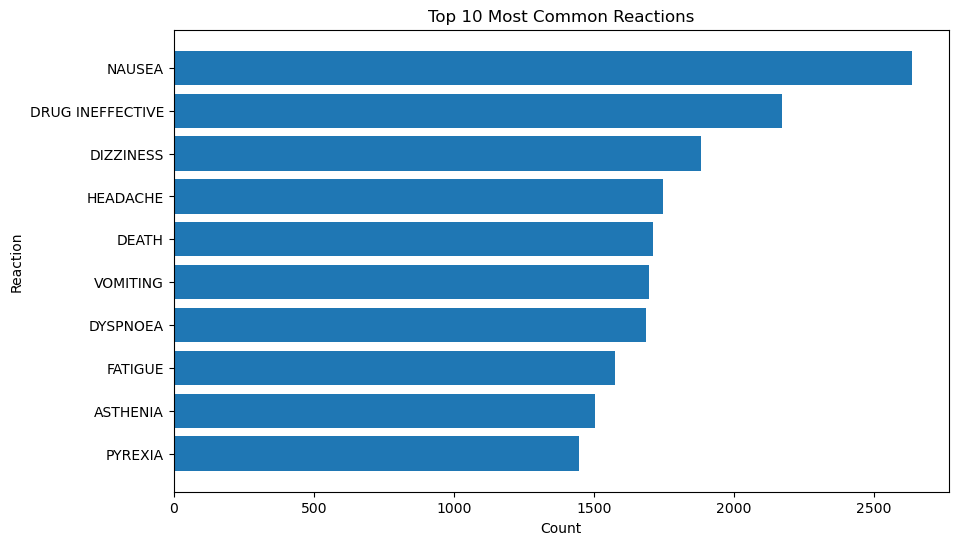

In [ ]:
from pyspark.sql.functions import explode

# Explode `patient.reaction` field and access `reactionmeddrapt`
reaction_counts = (
    df.select(explode(col("`patient.reaction`")).alias("reaction"))
    .groupBy(col("reaction.reactionmeddrapt"))
    .count()
    .orderBy(col("count").desc())
    .limit(10)
)

# Convert to Pandas for visualization
reaction_counts_pd = reaction_counts.toPandas()

# Bar plot using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(reaction_counts_pd["reactionmeddrapt"], reaction_counts_pd["count"])
plt.xlabel("Count")
plt.ylabel("Reaction")
plt.title("Top 10 Most Common Reactions")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
#Query 4: Most Common Drugs


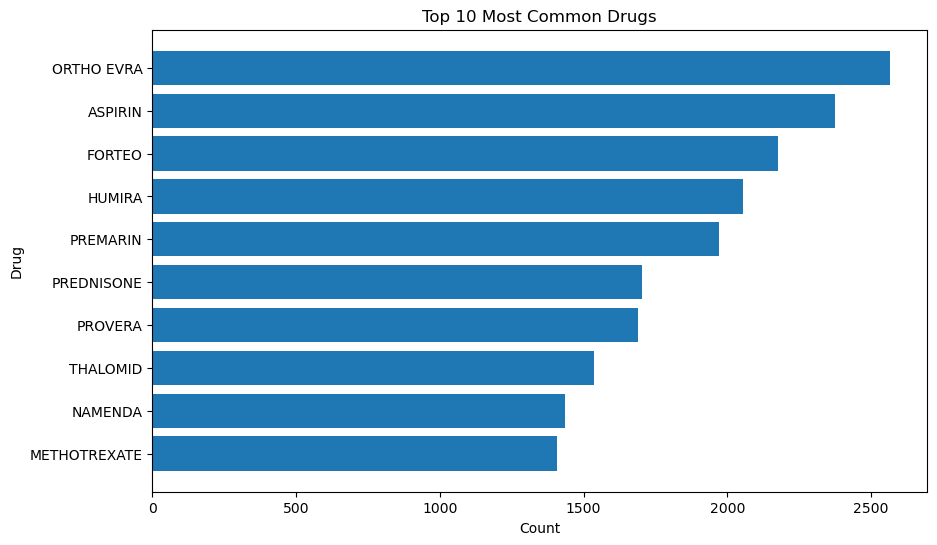

In [ ]:
# Explode `patient.drug` field and access `medicinalproduct`
drug_counts = (
    df.select(explode(col("`patient.drug`")).alias("drug"))
    .groupBy(col("drug.medicinalproduct"))
    .count()
    .orderBy(col("count").desc())
    .limit(10)
)

# Convert to Pandas for visualization
drug_counts_pd = drug_counts.toPandas()

# Bar plot using Matplotlib
plt.figure(figsize=(10, 6))
plt.barh(drug_counts_pd["medicinalproduct"], drug_counts_pd["count"])
plt.xlabel("Count")
plt.ylabel("Drug")
plt.title("Top 10 Most Common Drugs")
plt.gca().invert_yaxis()
plt.show()


In [ ]:
# Query 5: Clustering Patients by Reactions and Drugs


In [ ]:
from pyspark.ml.feature import Tokenizer, CountVectorizer
from pyspark.ml.clustering import KMeans

# Explode `patient.reaction` and select reaction text
reaction_df = (
    df.select(explode(col("`patient.reaction`")).alias("reaction"))
    .select(col("reaction.reactionmeddrapt").alias("reaction"))
    .na.drop()
)

# Tokenize reaction text into words (if reaction is a phrase)
tokenizer = Tokenizer(inputCol="reaction", outputCol="reaction_tokens")
tokenized_reaction_df = tokenizer.transform(reaction_df)

# Vectorize tokens
vectorizer = CountVectorizer(inputCol="reaction_tokens", outputCol="features")
vectorized_reaction = vectorizer.fit(tokenized_reaction_df).transform(tokenized_reaction_df)

# Apply KMeans clustering
kmeans = KMeans(k=5, featuresCol="features", predictionCol="cluster")
model = kmeans.fit(vectorized_reaction)

# Analyze clusters
clusters = model.transform(vectorized_reaction)
clusters.show()

# Visualize cluster sizes
cluster_sizes = clusters.groupBy("cluster").count().toPandas()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(cluster_sizes["cluster"], cluster_sizes["count"])
plt.xlabel("Cluster")
plt.ylabel("Number of Reactions")
plt.title("Cluster Sizes")
plt.show()


ConnectionRefusedError: [Errno 61] Connection refused